In [1]:
from utils import *
import torch
import webdataset as wds
from itertools import islice
def selectLabel(x,lbl):
    # function to select desired label
    lbl_idx = ["id","sex","age","handedness","index"].index(lbl.lower())
    x = x.decode("utf-8").split(",")[lbl_idx]
    return x if lbl_idx == 0 else float(x)

def add_chan_dim(x):
    x = torch.tensor(x)
#     x = torch.transpose(x, 0, 1)
    return torch.unsqueeze(x,0)

s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_train.tar' # replace 'train' with 'val' and 'test' accordingly
train_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_val.tar' # replace 'train' with 'val' and 'test' accordingly
val_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

# Check out first sample and its label
sample, label = next(iter(train_data))
print(f'Sample size: {sample.shape}') # (24, 256)
print(f'Label: {label}') # NDARFB908HVX

Sample size: torch.Size([1, 24, 256])
Label: 0.0


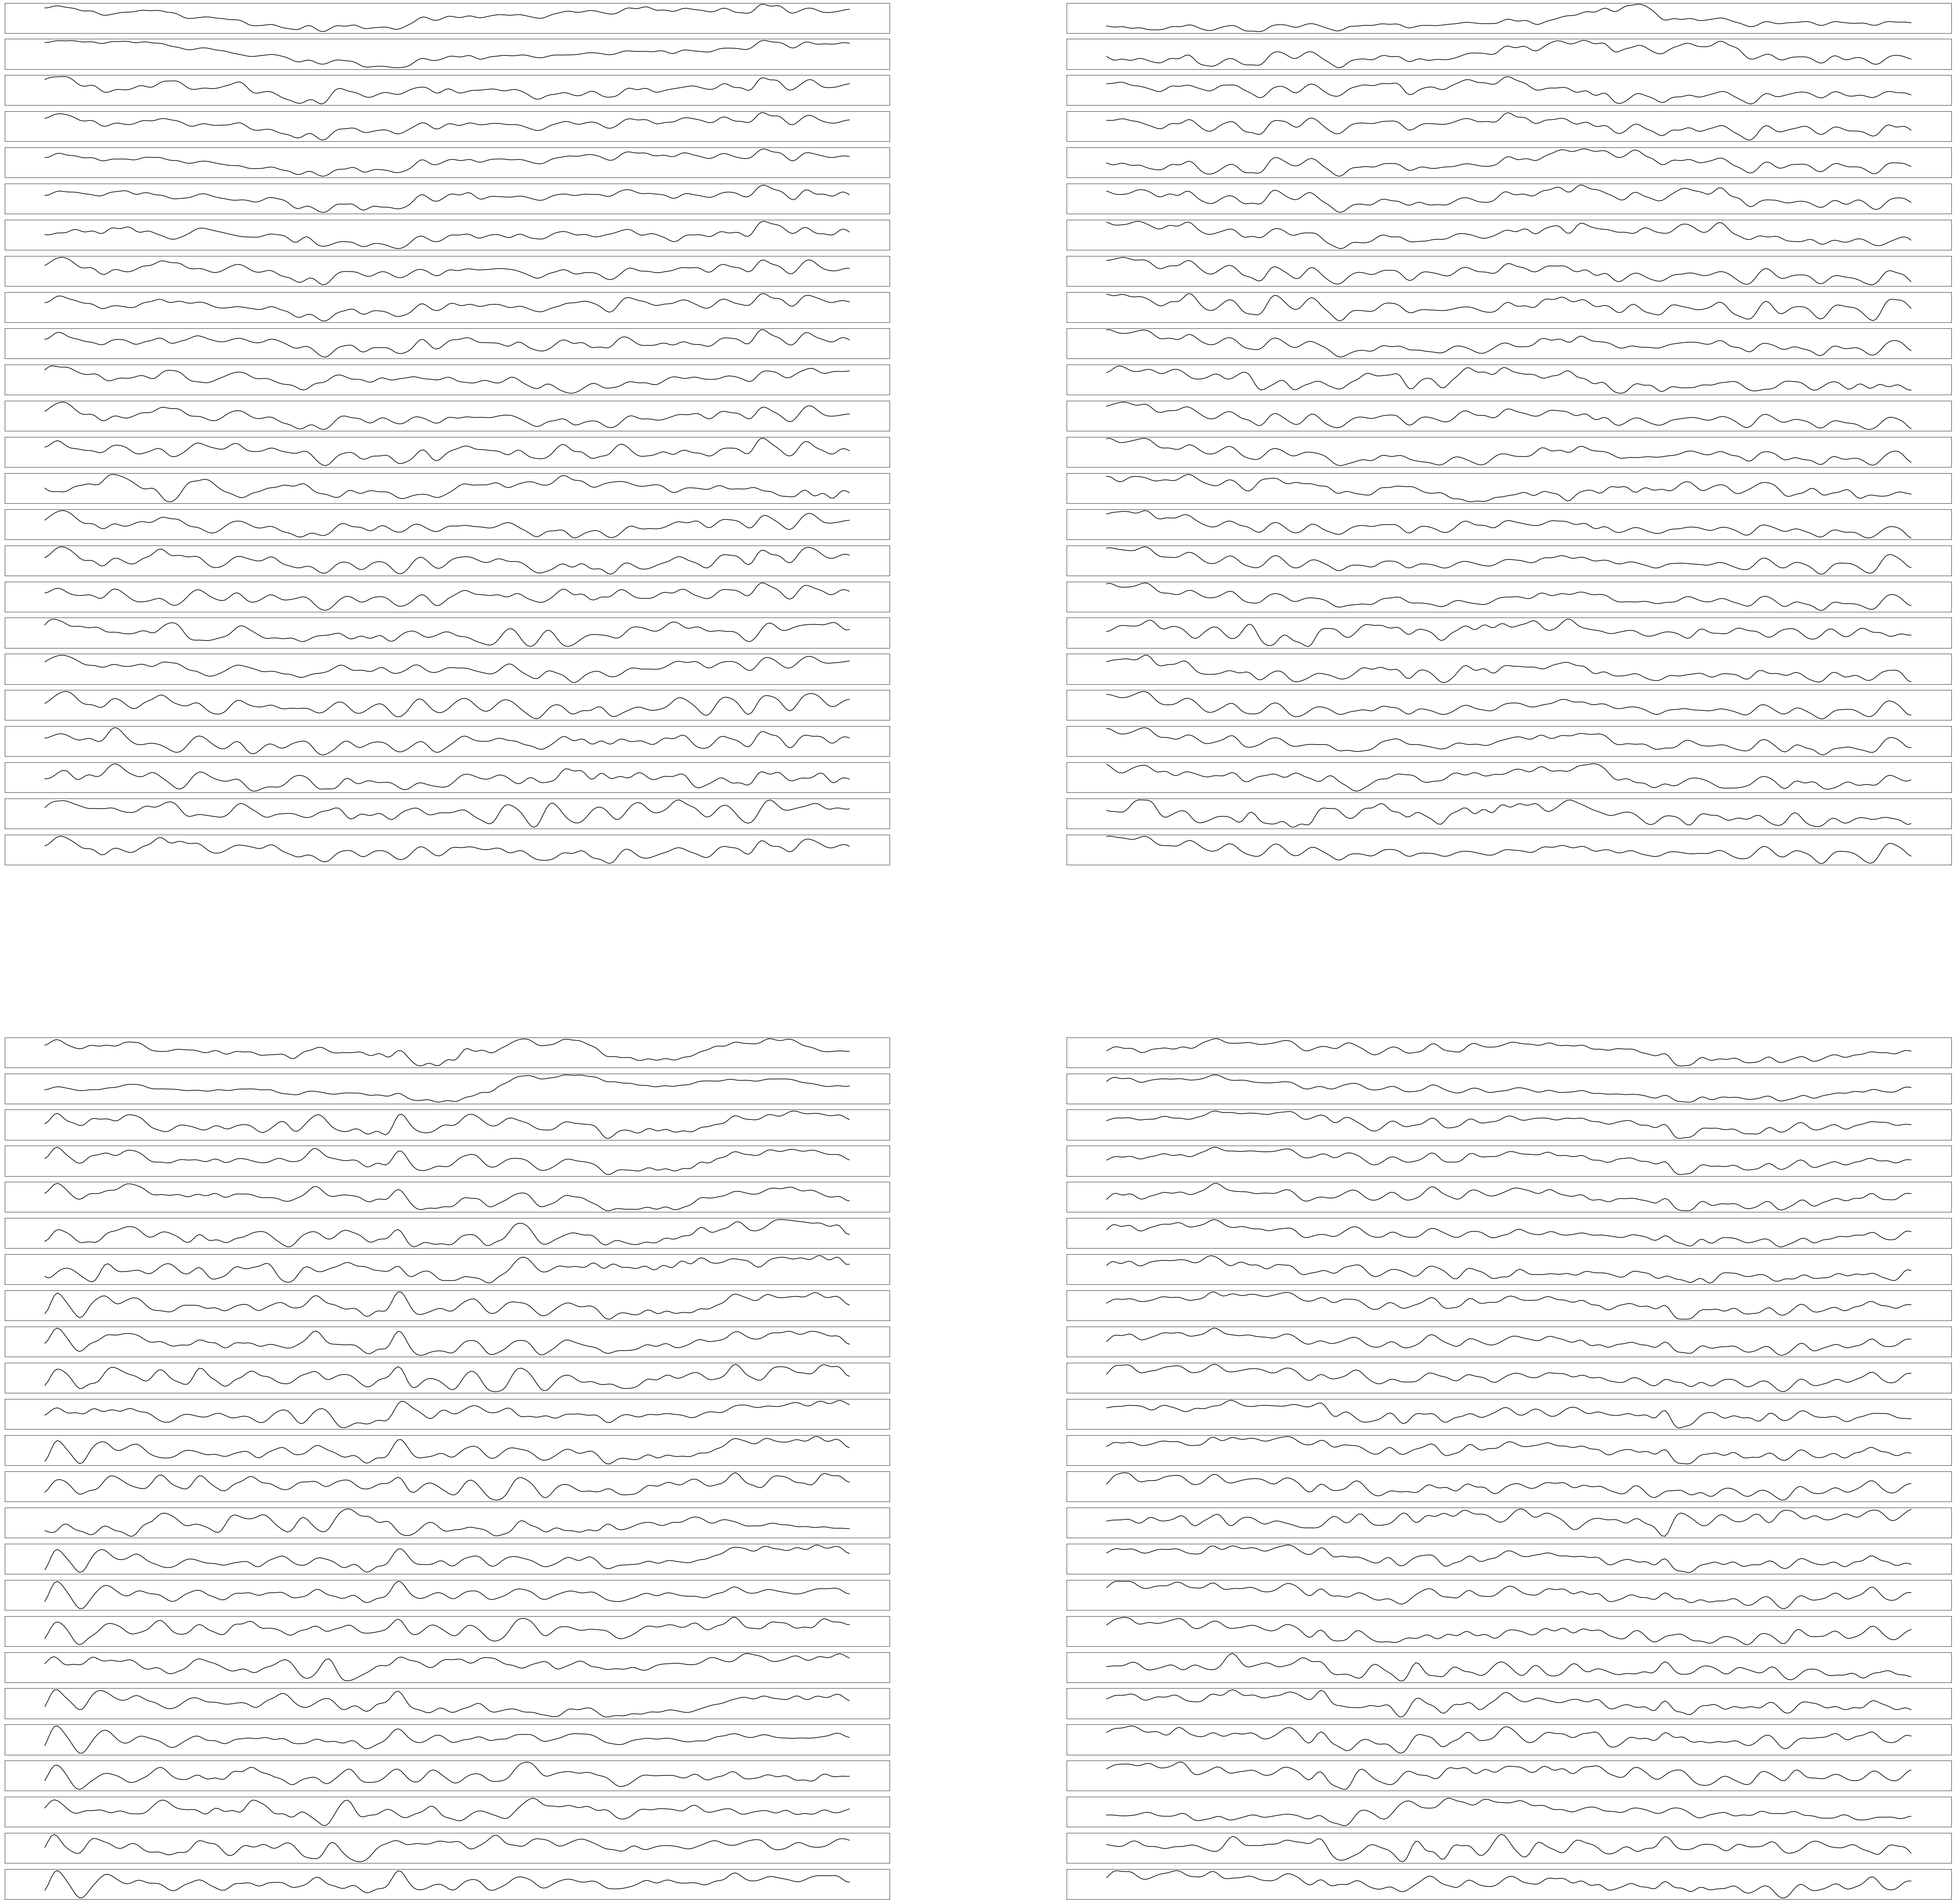

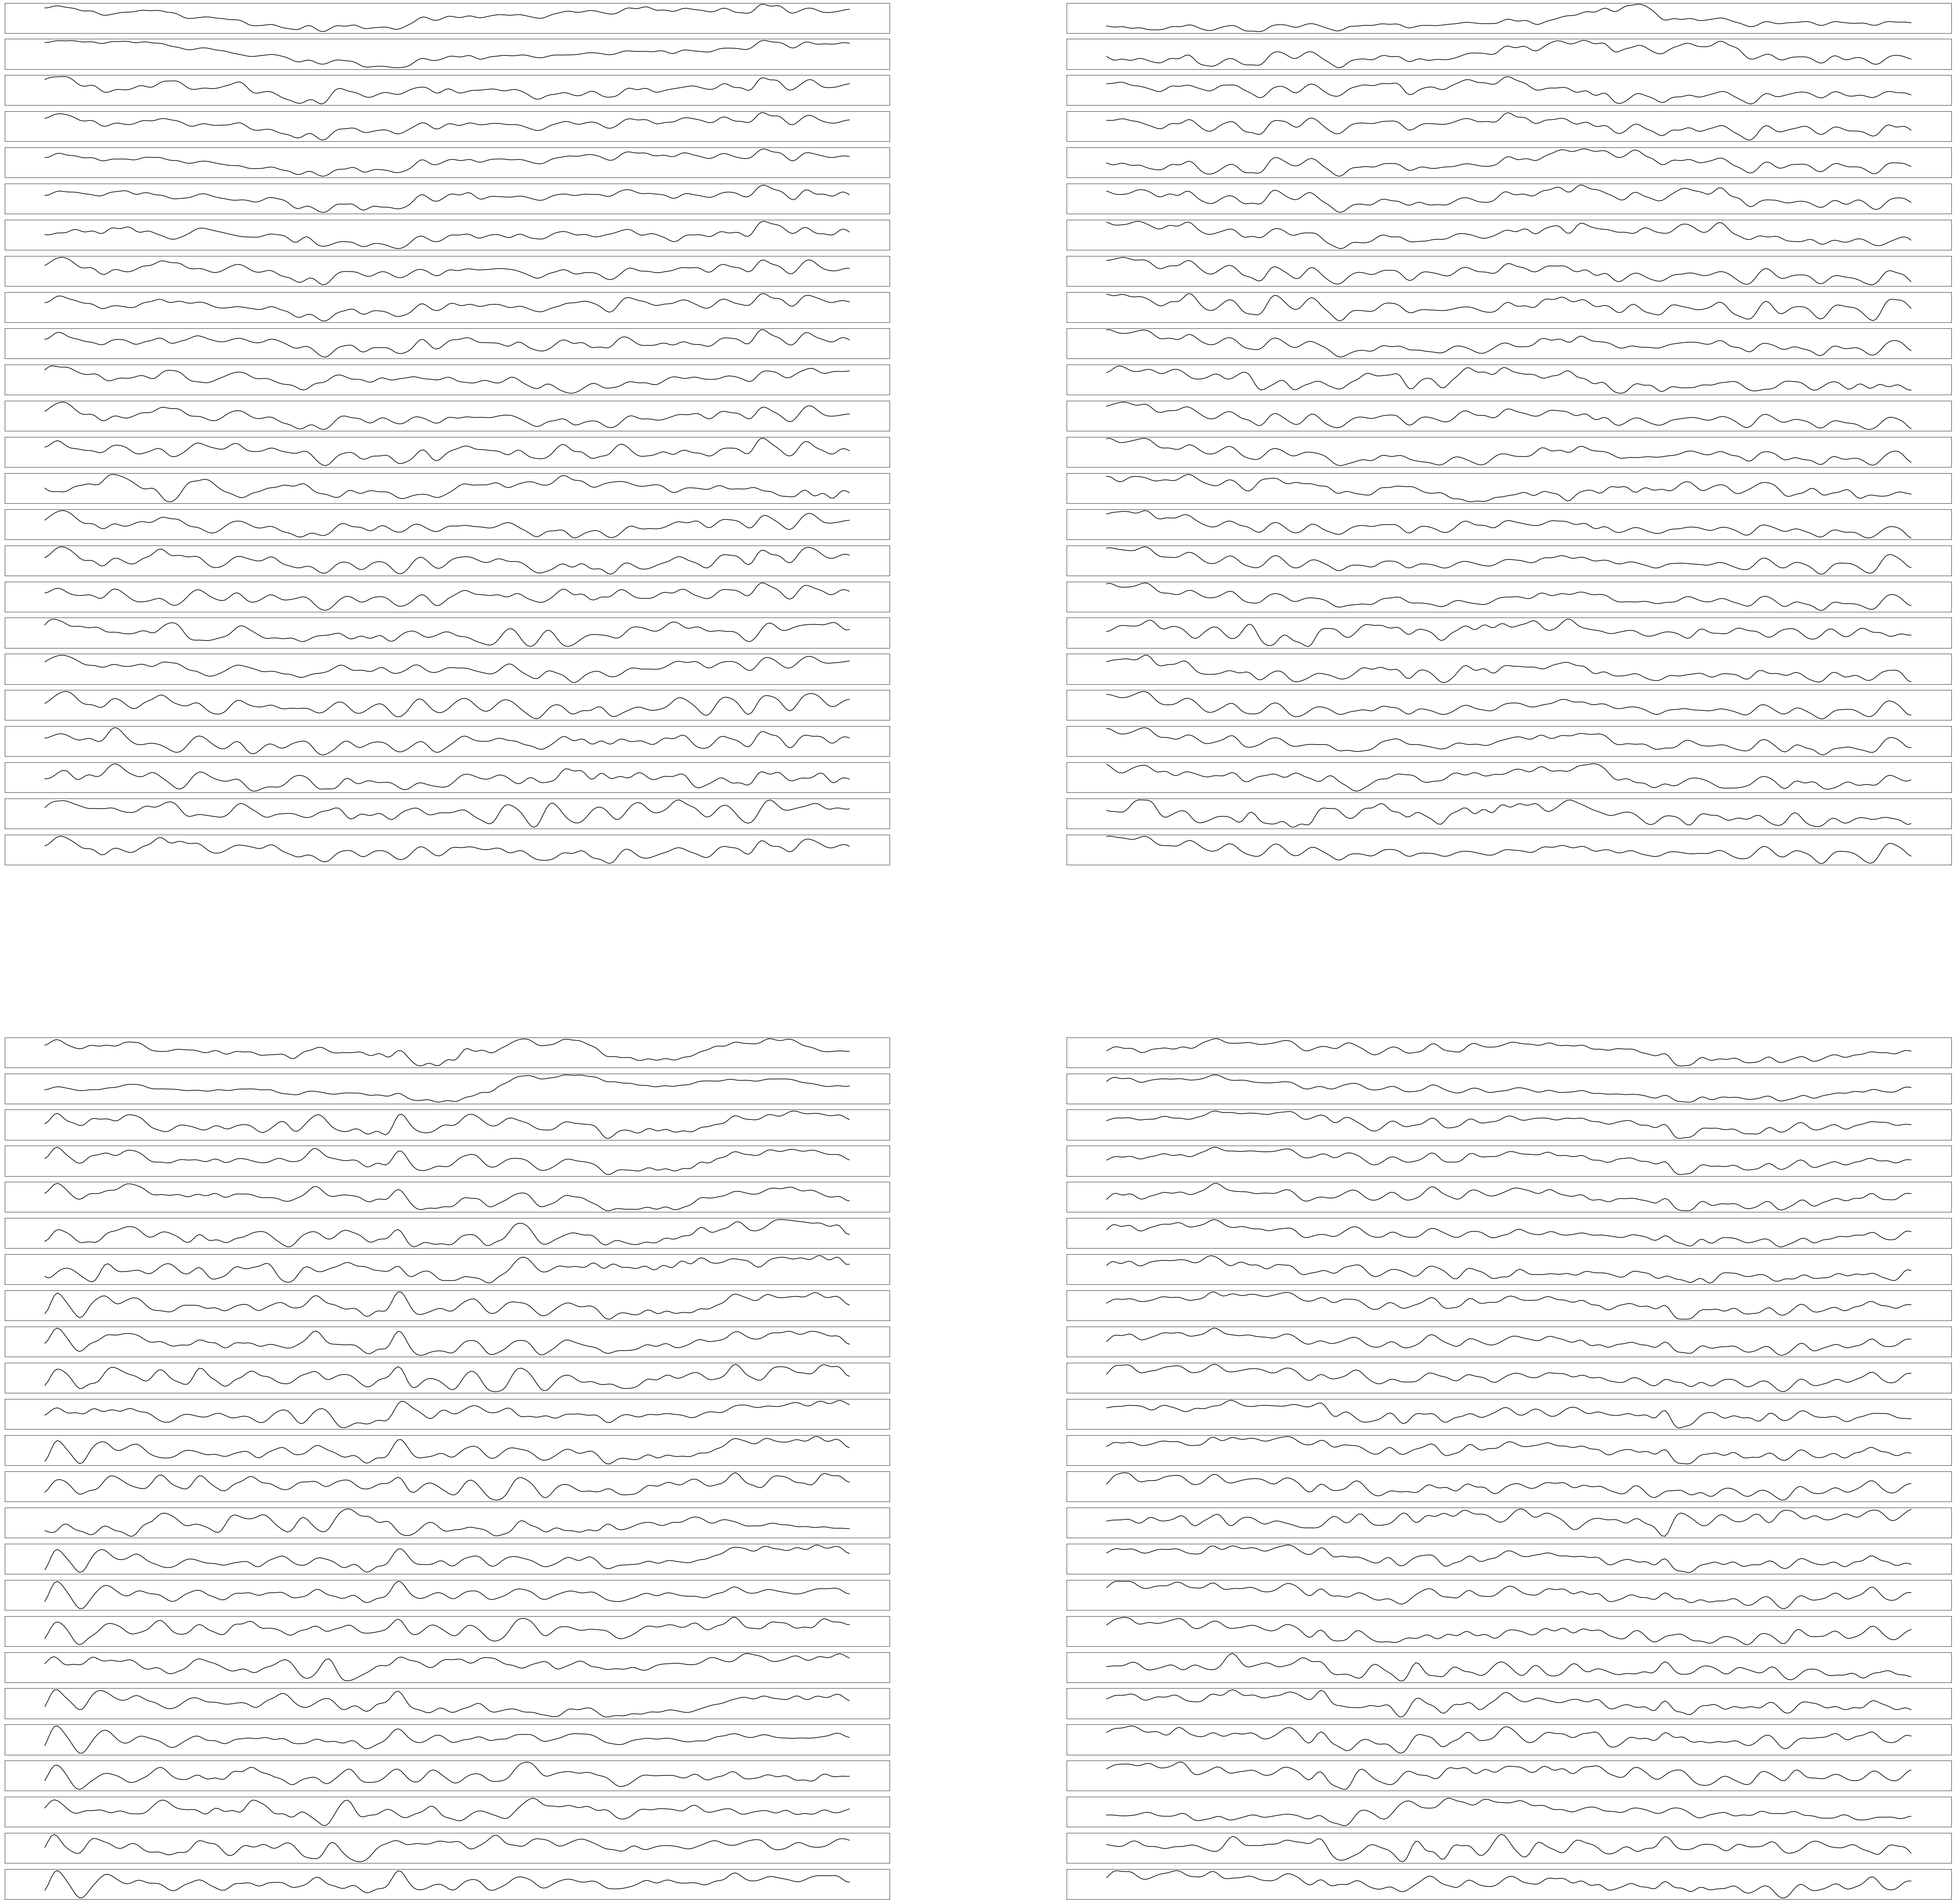

In [2]:
def plot_EEG(data, numChan):
    iter_data = iter(data)
    fig = plt.figure(figsize=(80, 80))
    outer = gridspec.GridSpec(2, 2)
    for i in range(4):
        inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                        subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
        npimg, label = next(iter_data)
        npimg = torch.squeeze(npimg)
        yax = None
        for j in range(24):
            ax = plt.Subplot(fig, inner[j])
            ax.plot(range(256),npimg[j,:],'k')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

    return fig
plot_EEG(train_data, 24)

In [3]:
# default env params
winLength = 2
numChan = 24
srate = 128
feature = 'raw'

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [4]:
model = create_model('vgg',feature)
from pytorch_model_summary import summary
print(summary(model, torch.zeros((1, 1, 24, 256)), show_input=False))

------------------------------------------------------------------------
      Layer (type)         Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 16, 24, 256]             160             160
            ReLU-2     [1, 16, 24, 256]               0               0
          Conv2d-3     [1, 16, 24, 256]           2,320           2,320
            ReLU-4     [1, 16, 24, 256]               0               0
       MaxPool2d-5     [1, 16, 12, 128]               0               0
          Conv2d-6     [1, 32, 12, 128]           4,640           4,640
            ReLU-7     [1, 32, 12, 128]               0               0
          Conv2d-8     [1, 32, 12, 128]           9,248           9,248
            ReLU-9     [1, 32, 12, 128]               0               0
      MaxPool2d-10       [1, 32, 6, 64]               0               0
         Conv2d-11       [1, 64, 6, 64]          18,496          18,496
           ReLU-12       [1, 64, 6, 64]               0        

In [7]:
logger = Logger()
batch_size = 70 # original
loader_train = DataLoader(train_data, batch_size=batch_size)
loader_val = DataLoader(val_data, batch_size=batch_size)
for s in range(2):
    model = run_experiment(s, loader_train, loader_val, 'original', 'raw', 1, logger, device, dtype)

Begin trainning...
04/09 10:00:40 PM Epoch 0, Iteration 0, loss = 0.4644
04/09 10:00:44 PM Epoch 0, Iteration 100, loss = 0.0000
04/09 10:00:48 PM Epoch 0, Iteration 200, loss = 0.0000
04/09 10:00:52 PM Epoch 0, Iteration 300, loss = 1.3014
04/09 10:00:56 PM Epoch 0, Iteration 400, loss = 0.4518
04/09 10:01:00 PM Epoch 0, Iteration 500, loss = 0.6919
04/09 10:01:04 PM Epoch 0, Iteration 600, loss = 0.5383
04/09 10:01:08 PM Epoch 0, Iteration 700, loss = 0.3854
04/09 10:01:12 PM Epoch 0, Iteration 800, loss = 0.2575
04/09 10:01:16 PM Epoch 0, Iteration 900, loss = 0.1298
04/09 10:01:18 PM Epoch 0, Iteration 1000, loss = 0.1764
04/09 10:01:18 PM Checking accuracy on training set
04/09 10:02:00 PM Got 35431 / 71138 correct (49.81)
04/09 10:02:00 PM Checking accuracy on validation set
04/09 10:02:29 PM Got 19877 / 39641 correct (50.14)
04/09 10:02:29 PM 
04/09 10:02:36 PM Epoch 1, Iteration 0, loss = 3.5282
04/09 10:02:40 PM Epoch 1, Iteration 100, loss = 0.0002
04/09 10:02:44 PM Epoch 1, 

KeyboardInterrupt: 

In [51]:
logger = Logger(mode='debug')
role = 'test'
# path = '/expanse/projects/nemar/dtyoung/DL-EEG/data/'
def add_chan_dim(x):
    x = torch.tensor(x)
    x = torch.transpose(x, 0, 1)
    return torch.unsqueeze(x,0)
s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/test.tar' # replace 'train' with 'val' and 'test' accordingly
test_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim).to_tuple("npy","cls")

# test_data = load_data(path, role, winLength, numChan, srate, feature, False)

sample_acc, subject_acc = test_all_seeds("/expanse/projects/nemar/dtyoung/DL-EEG/saved-model/vgg-raw/model-vgg-raw", 'vgg',feature,test_data,'/expanse/projects/nemar/dtyoung/DL-EEG/data/test_subjIDs_fewer_subjects.csv',10, 1,device, dtype,logger)
min_sample = np.min(sample_acc)
max_sample = np.max(sample_acc)
mean_sample = np.mean(sample_acc)
std_sample = np.std(sample_acc)

min_subj = np.min(subject_acc)
max_subj = np.max(subject_acc)
mean_subj = np.mean(subject_acc)
std_subj = np.std(subject_acc)

logger.log("Per sample")
logger.log(f"Min: {min_sample}, Max: {max_sample}, Mean: {mean_sample}, STDEV: {std_sample}")

logger.log("Per subject")
logger.log(f"Min: {min_subj}, Max: {max_subj}, Mean: {mean_subj}, STDEV: {std_subj}")


Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 13032 / 15925 correct (81.83)
Testing model accuracy using 40-segment per subject metric


AssertionError: 